In [201]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [202]:
data = pd.read_csv('breastcancer.csv')
del data['Unnamed: 0']

In [246]:
data.head()

,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,benign
1,1002945,5,4,4,5,7,10,3,2,1,benign
2,1015425,3,1,1,1,2,2,3,1,1,benign
3,1016277,6,8,8,1,3,4,3,7,1,benign
4,1017023,4,1,1,3,2,1,3,1,1,benign


In [203]:
#should I drop the ID column???
X = data.drop(['Id','Class'], axis=1)
y = data.Class

## Question a - Cross validation to build a classifier

- Step 1 : Impute missing values
- Step 2 : Split into training and testing set according to an arbitrary percentage
- Step 3 : Scale continuous variables from training and testing set according to the same transformation
- Step 4 : For a particular kernel apply k-fold cross validation on the training set for several parameters. Compute performances on each validation set and average them for each couple of parameters
- Step 5 : Select the model that maximizes the performance
- Step 6 : Compute test error with this classifier.

### Sources scikit-learn : 
Impute missing values : http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values

Cross validation and scaling : http://scikit-learn.org/stable/modules/cross_validation.html

SVM : http://scikit-learn.org/stable/modules/svm.html#svm
    
    

In [367]:
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import svm
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

#### Step 1 : impute missing values with the most frequent value
imp = preprocessing.Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp.fit(X)
X_imp = pd.DataFrame(imp.transform(X), columns = X.columns)


#### Step 2 : Split into training / testing sets

# set the split ratio : 0.7 for training set
# set random state to 0
t = 0.7
rdm = 0

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_imp, y, test_size = 1 - t, random_state = rdm)


#### Step 3 : scaling but here all variables are categorical or ordinal
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)


#### Test SVM for C = 1, kernel function is RBF and gamma = 1/n_features in 'auto' mode
clf = svm.SVC(C=1, gamma = 0.1, kernel = 'rbf', random_state = 0)
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
# get support vectors
clf.support_vectors_
# get indices of support vectors
clf.support_
# get number of support vectors for each class
clf.n_support_


#### Step 4 : k-fold on the training set
sample_size = len(X_train)
K = 10
kf = KFold(sample_size, n_folds = K) 


# we define the mean CV performance for each value of C
mean_perf = dict()

for Cpow in range(-3,5):
    for Gpow in range(-5,3):
            C = 10**Cpow
            gamma = 10**Gpow
            mean_perf[(Cpow,Gpow)] = []
            
            clf = svm.SVC(C = C, gamma = gamma, kernel = 'rbf', random_state = 0)

            CV_perf = [] 
            # kf has 2 outputs : train and test
            for train, test in kf:

                train_fold, test_fold, train_output, test_output = \
                        X_train.iloc[train], X_train.iloc[test], y_train.iloc[train], y_train.iloc[test]

                clf.fit(train_fold, train_output)
                pred_test = clf.predict(test_fold)

                CV_perf.append(accuracy_score(test_output, pred_test))

            mean_perf[(Cpow,Gpow)] = np.mean(CV_perf)
            
print('We apply k-fold cross validation for k = '+ str(K) + \
     ' to select the best SVM classifier with a radial basis function kernel.\n\n')  

#### Step 5 : Select best classifier 
# get key with maximum value
max_key = max(mean_perf, key=lambda i: mean_perf[i])
best_C = 10**max_key[0]
best_gamma = 10**max_key[1]
max_accu = round(float(mean_perf[max_key]),3)

print('The couple of parameters which maximizes the average cross-validation performance are (C , Gamma) = (' \
      + str(best_C) + ' , ' + str(best_gamma) + \
        '). \nIn this case, the accuracy is ' + str(max_accu) + '.\n\n')


#### Step 6 : Fit new model on entire training set and test it
clf = svm.SVC(C = best_C, gamma = best_gamma, kernel = 'rbf', random_state = 0)
clf.fit(X_train, y_train)
pred_test = clf.predict(X_test)
test_perf = round(float(accuracy_score(y_test, pred_test)), 3)
test_err = round(1 - test_perf,3)

print('We fit the selected model on the entire training set and assess its performance on the testing set.' + \
     '\nThe accuracy on the test set is ' + str(test_perf) + ' or the generalization error is ' + str(test_err) +'.\n')

We apply k-fold cross validation for k = 10 to select the best SVM classifier with a radial basis function kernel.


The couple of parameters which maximizes the average cross-validation performance are (C , Gamma) = (0.1 , 0.01). 
In this case, the accuracy is 0.978.


We fit the selected model on the entire training set and assess its performance on the testing set.
The accuracy on the test set is 0.943 or the generalization error is 0.057.



To plot a 3D graph : http://matplotlib.org/examples/mplot3d/surface3d_demo.html 

## Question b - Repeat the procedure 50 times with different random samples

Create a function with two inputs :
    - the split ratio 
    - the random state 
    
Compute mean and standard deviation.

Plot graphs

In [374]:
def SVM_test_performance(t, rdm):

    #### Step 2 : Split into training / testing sets
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_imp, y, test_size = 1 - t, random_state = rdm)


    #### Step 4 : k-fold on the training set
    sample_size = len(X_train)
    K = 10
    kf = KFold(sample_size, n_folds = K) 


    # we define the mean CV performance for each value of C
    mean_perf = dict()

    for Cpow in range(-3,2):
        for Gpow in range(-4,2):
                C = 10**Cpow
                gamma = 10**Gpow
                mean_perf[(Cpow,Gpow)] = []

                clf = svm.SVC(C = C, gamma = gamma, kernel = 'rbf', random_state = rdm)

                CV_perf = [] 
                # kf has 2 outputs : train and test
                for train, test in kf:

                    train_fold, test_fold, train_output, test_output = \
                            X_train.iloc[train], X_train.iloc[test], y_train.iloc[train], y_train.iloc[test]

                    clf.fit(train_fold, train_output)
                    pred_test = clf.predict(test_fold)

                    CV_perf.append(accuracy_score(test_output, pred_test))

                mean_perf[(Cpow,Gpow)] = np.mean(CV_perf)


    #### Step 5 : Select best classifier 
    # get key with maximum value
    max_key = max(mean_perf, key=lambda i: mean_perf[i])
    best_C = 10**max_key[0]
    best_gamma = 10**max_key[1]
    max_accu = round(float(mean_perf[max_key]),3)


    #### Step 6 : Fit new model on entire training set and test it
    clf = svm.SVC(C = best_C, gamma = best_gamma, kernel = 'rbf', random_state = rdm)
    clf.fit(X_train, y_train)
    pred_test = clf.predict(X_test)
    test_perf = float(accuracy_score(y_test, pred_test))

    return(test_perf)


In [382]:
test_perf = []
for i in range(50):
    test_perf.append(SVM_test_performance(0.7,i))

In [383]:
mean_test_perf = np.mean(test_perf)
std_test_perf = np.std(test_perf)

print('After repeating 50 times the same experiment on different samples, we get an average performance of ' + \
     str(round(mean_test_perf,3)) + '\nand a standard deviation of ' + str(round(std_test_perf,3)) + \
     ' on the testing set.')

After repeating 50 times the same experiment on different samples, we get an average performance of 0.962
and a standard deviation of 0.011 on the testing set.


## Question c - Repeat the previous procedure for several values of t

In [384]:
perf = dict()

for i in range(10):
    split_ratio = round(0.5 + 0.05*i,2)
    perf[split_ratio] = []
    
    test_perf = []
    for i in range(50):
        test_perf.append(SVM_test_performance(split_ratio,i))
    
    perf[split_ratio].append(np.mean(test_perf))
    perf[split_ratio].append(np.std(test_perf))

In [385]:
perf

{0.5: [0.96440000000000015, 0.0059716336260076542],
 0.55: [0.96438095238095234, 0.0085015375130422007],
 0.6: [0.96342857142857152, 0.0085880790658223564],
 0.65: [0.9641632653061224, 0.010139879659880986],
 0.7: [0.96199999999999986, 0.011044745110586437],
 0.75: [0.96240000000000014, 0.012207190921914897],
 0.8: [0.96242857142857152, 0.01497003810336923],
 0.85: [0.96438095238095212, 0.017950296708618436],
 0.9: [0.96685714285714264, 0.019046666642855963],
 0.95: [0.95999999999999996, 0.02740475156178698]}

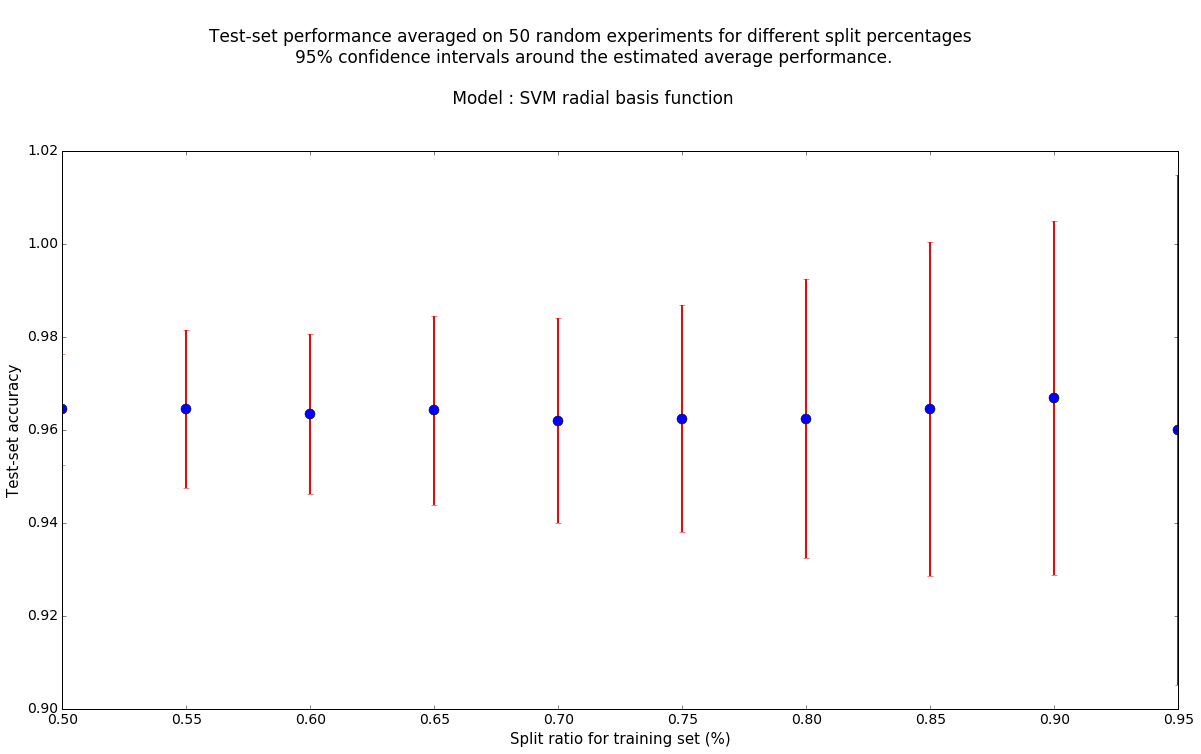

In [462]:
plt.figure(figsize=(20, 10)) 

split_ratio = list(perf.keys())

test_mean = []
test_std = []

for i in range(len(perf)):
    test_mean.append(list(perf.values())[i][0])
    test_std.append(2*list(perf.values())[i][1]) # 95% confidence intervals

    
plt.errorbar(split_ratio, test_mean, test_std, linestyle='None', fmt='-o', ecolor = 'red', markersize='10', elinewidth=2)
plt.title('\nTest-set performance averaged on 50 random experiments for different split percentages \
          \n95% confidence intervals around the estimated average performance.\
          \n\n Model : SVM radial basis function \
          \n  \n', fontsize = 17)  
plt.ylabel('Test-set accuracy', fontsize = 15)
plt.xlabel('Split ratio for training set (%)', fontsize = 15)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)

plt.show()